<a href="https://www.kaggle.com/code/ebruiserisobay/arl-association-rule-learning-armut-company?scriptVersionId=189631256" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

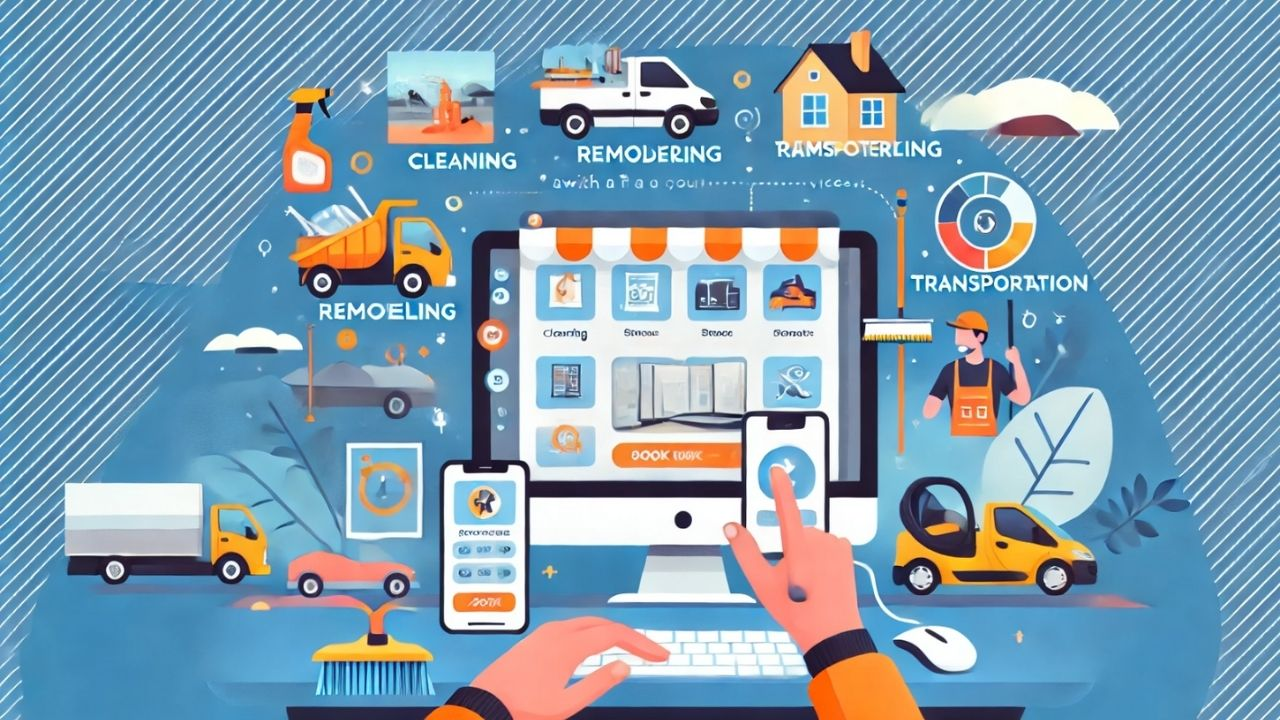
# Association Rule Learning (ARL)

## 1. Business Problem

Armut, the largest online service platform in Turkey, brings together service providers and service recipients. It provides easy access to services such as cleaning, remodeling and transportation with a few taps on your computer or smartphone. A product recommendation system was created with Association Rule Learning using a data set that includes service users and the services and categories that these users have received.

## 2. About Dataset

The dataset consists of services taken by customers and the categories of these services.
Each purchased service includes date and time information.

* **UserId:** Customer number

* **ServiceId:** Anonymized services for each category. (Example: A sofa cleaning service under the cleaning category)

  A ServiceId can be found under different categories and represent different services under different categories.
  (Example: The service with CategoryId 7 and ServiceId 4 is radiator cleaning, while the service with CategoryId 2 and ServiceId 4 is furniture assembly)

* **CategoryId:** Anonymized categories. (Example: cleaning, moving, renovation categories.

* **CreateDate:** The date the service was purchased

## 3. Data Preparing & Understanding

In [1]:
import numpy as np
import pandas as pd
!pip install mlxtend
from mlxtend.frequent_patterns import apriori, association_rules
import datetime as dt

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 500)

In [2]:
df_ = pd.read_csv('/kaggle/input/armut-dataset/armut_data.csv') #upload the dataset

In [3]:
df = df_.copy() # copy the dataset to protect original dataset

In [4]:
df.head() #display first 5 rows

,UserId,ServiceId,CategoryId,CreateDate
0,25446,4,5,2017-08-06 16:11:00
1,22948,48,5,2017-08-06 16:12:00
2,10618,0,8,2017-08-06 16:13:00
3,7256,9,4,2017-08-06 16:14:00
4,25446,48,5,2017-08-06 16:16:00


In [5]:
df.shape #display the shape of the dataset

(162523, 4)

In [6]:
df.info() #info about dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162523 entries, 0 to 162522
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   UserId      162523 non-null  int64 
 1   ServiceId   162523 non-null  int64 
 2   CategoryId  162523 non-null  int64 
 3   CreateDate  162523 non-null  object
dtypes: int64(3), object(1)
memory usage: 5.0+ MB


In [7]:
# The ServiceID represents a different service for each specific CategoryID.
# Creating a new variable to represent the services by combining the ServiceID and CategoryID with an underscore ("_").

df["Service"] = df["ServiceId"].astype("str") + "_" + df["CategoryId"].astype("str")

df.head() #display first 5 rows

,UserId,ServiceId,CategoryId,CreateDate,Service
0,25446,4,5,2017-08-06 16:11:00,4_5
1,22948,48,5,2017-08-06 16:12:00,48_5
2,10618,0,8,2017-08-06 16:13:00,0_8
3,7256,9,4,2017-08-06 16:14:00,9_4
4,25446,48,5,2017-08-06 16:16:00,48_5


> **NOTE:** 
> 
> * The dataset consists of the date and time when services were taken, and it does not include any basket definitions (e.g., invoice).
> 
> * To apply Association Rule Learning, a basket (e.g., invoice) definition has been created.
> 
> * Here, the basket definition is the services taken monthly by each customer. 
> 
>  * For example, the services 9_4 and 46_4 taken by the customer with ID 7256 in August 2017 represent one basket;the services 9_4 and 38_4 taken in October 2017 represent another basket.

In [8]:
# Identifying the baskets with a unique ID:

df["CreateDate"] = pd.to_datetime(df["CreateDate"]) #converting date column to datetime type

df["New_Date"] = df["CreateDate"].dt.to_period("M") #creating a new column which includes "month-year"

df["BasketID"] = df["UserId"].astype("str") + "_" + df["New_Date"].astype("str") #combining the UserId and New_Date with an underscore ("_")

df.head() #display first 5 rows

,UserId,ServiceId,CategoryId,CreateDate,Service,New_Date,BasketID
0,25446,4,5,2017-08-06 16:11:00,4_5,2017-08,25446_2017-08
1,22948,48,5,2017-08-06 16:12:00,48_5,2017-08,22948_2017-08
2,10618,0,8,2017-08-06 16:13:00,0_8,2017-08,10618_2017-08
3,7256,9,4,2017-08-06 16:14:00,9_4,2017-08,7256_2017-08
4,25446,48,5,2017-08-06 16:16:00,48_5,2017-08,25446_2017-08


In [9]:
df.info() #check the datatype again

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162523 entries, 0 to 162522
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   UserId      162523 non-null  int64         
 1   ServiceId   162523 non-null  int64         
 2   CategoryId  162523 non-null  int64         
 3   CreateDate  162523 non-null  datetime64[ns]
 4   Service     162523 non-null  object        
 5   New_Date    162523 non-null  period[M]     
 6   BasketID    162523 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2), period[M](1)
memory usage: 8.7+ MB


# 4. Preparing "Basket - Service Matrix"

In [10]:
# Defining "a basket-service pivot table" function:

def create_invoice_product_df(dataframe):
    return df.pivot_table(
    values ='UserId',
    index ='BasketID',
    columns='Service',
    aggfunc={'UserId': 'count'}).\
    fillna(0).\
    applymap(lambda x: 1 if x>0 else 0)


In [11]:
# apply the function:

inv_pro_df = create_invoice_product_df(df) 

inv_pro_df.iloc[0:6,0:6] #display first 5 columns & rows 

/tmp/ipykernel_19/166484105.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  applymap(lambda x: 1 if x>0 else 0)


Service,0_8,10_9,11_11,12_7,13_11,14_7
BasketID,,,,,,
0_2017-08,0,0,0,0,0,0
0_2017-09,0,0,0,0,0,0
0_2018-01,0,0,0,0,0,0
0_2018-04,0,0,0,0,0,1
10000_2017-08,0,0,0,0,0,0
10000_2017-12,1,0,0,0,0,0


## 5. Association Rules Analysis

In [12]:
# Apriori Algorithm:

frequent_itemsets = apriori(inv_pro_df, min_support=0.01, use_colnames=True) # applying

frequent_itemsets.sort_values("support",ascending=False).head() # sorting

/opt/conda/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
8,0.238121,(18_4)
19,0.130286,(2_0)
5,0.120963,(15_1)
39,0.067762,(49_1)
28,0.066568,(38_4)


In [13]:
# creating association rules:
    
rules = association_rules(frequent_itemsets, metric='support', min_threshold=0.01)

rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(2_0),(13_11),0.130286,0.056627,0.012819,0.098394,1.737574,0.005442,1.046325,0.488074
1,(13_11),(2_0),0.056627,0.130286,0.012819,0.226382,1.737574,0.005442,1.124216,0.449965
2,(2_0),(15_1),0.130286,0.120963,0.033951,0.260588,2.154278,0.018191,1.188833,0.616073
3,(15_1),(2_0),0.120963,0.130286,0.033951,0.280673,2.154278,0.018191,1.209066,0.609539
4,(33_4),(15_1),0.027310,0.120963,0.011233,0.411311,3.400299,0.007929,1.493211,0.725728


## 6. Association Rules Learning (ARL) Recommender 

In [14]:
# Defining ARL recommender function:

def arl_recommender(rules_df,hizmet_id,rec_count=1):
    sorted_rules = rules_df.sort_values(by='lift', ascending=False)
    recommendation_list = []
    for i, product in enumerate(sorted_rules["antecedents"]):
        for j in list(product):
            if j == hizmet_id :
                recommendation_list.append(list(sorted_rules.iloc[i]["consequents"])[0])
    return recommendation_list[0:rec_count]

In [15]:
# Recommending 4 services to a user who last received service "2_0":

arl_recommender(rules,"2_0",4)

['22_0', '25_0', '15_1', '13_11']